In [1]:
import matplotlib.pyplot as plt
import numpy as np
import random
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_datasets as tfds
from glob import glob
import cv2
from tqdm.auto import tqdm
import os

gpus = tf.config.experimental.list_physical_devices(device_type="GPU")
for gpu in gpus:
    tf.config.experimental.set_memory_growth(device=gpu,enable=True)

In [2]:
DATA_DIR=r'C:/Users/2103099/Documents//kaggle_fungi/'
# for Colab
# DATA_DIR='./Omniglot'

train_data_path = os.path.join(DATA_DIR, "target_s/target_s/")
val_data_path = os.path.join(DATA_DIR, "target_s/target_s_val/")

batch_size = 16
val_batch_size = 10
epochs = 10
inner_lr = 0.02

n_way = 3
k_shot = 4
q_query = 1

input_shape = (28, 28, 1)
outer_lr = 0.0001

# train_data_path 

In [3]:
# training v.s test Omniglot classes
source_classes = glob(DATA_DIR+'/target_s/target_s/*')
target_classes = glob(DATA_DIR+'/target_s/target_s_val/*')
print(f'字符種類 train: test = {len(source_classes)} : {len(target_classes)}')

字符種類 train: test = 110 : 22


In [4]:

# dataset 結構: images_background/語言/字符id
source_classes[:1]

target_classes [:1]

['C:/Users/2103099/Documents//kaggle_fungi//target_s/target_s_val\\11085_Xerocomellus_porosporus']

In [5]:
def __init__(self, data_path, batch_size, n_way=5, k_shot=3, q_query=1):
    """
    :param data_path: 資料夾下有子資料夾
    :param batch_size: 一個批次有多少個不同的task
    :param n_way: 一個task有幾類
    :param k_shot: 一個類別中有幾張圖片用於inner loop training
    :param q_query: 一個類別中有幾張圖片用於outer loop training
    """
    self.file_list = [f for f in glob(data_path + "**/?????_*", recursive=True)]
    self.steps = len(self.file_list) // batch_size

    self.n_way = n_way
    self.k_shot = k_shot
    self.q_query = q_query
    self.meta_batch_size = batch_size

In [7]:
file_list = [f for f in glob(train_data_path + "**/?????_*", recursive=True)]
# file_list = [f for f in glob(val_data_path + "**/?????_*", recursive=True)]
print( len(file_list))


steps = len(file_list) // batch_size
print(steps)



img_dirs = random.sample(file_list, 3)

# print(img_dirs)
# # support_image = []
# # support_label = []
# # query_image = []
# # query_label = []



n_way = 3
k_shot = 4
q_query = 1
for label, img_dir in enumerate(img_dirs):
    print("imgdir",len(img_dir))
    img_list = [f for f in glob(img_dir + "**/*.JPG", recursive=True)]
    print(len(img_list))
    images = random.sample(img_list, k_shot + q_query)
    print(images)

110
6
imgdir 85
5
['C:/Users/2103099/Documents//kaggle_fungi/target_s/target_s\\19009_Polyporus_tuberaster\\SVEND2010PIC69672322.JPG', 'C:/Users/2103099/Documents//kaggle_fungi/target_s/target_s\\19009_Polyporus_tuberaster\\TAK2012PIC26961243.JPG', 'C:/Users/2103099/Documents//kaggle_fungi/target_s/target_s\\19009_Polyporus_tuberaster\\FDE2015PIC73535101.JPG', 'C:/Users/2103099/Documents//kaggle_fungi/target_s/target_s\\19009_Polyporus_tuberaster\\JAJ2017-9197726_r1a6y8SBb.JPG', 'C:/Users/2103099/Documents//kaggle_fungi/target_s/target_s\\19009_Polyporus_tuberaster\\TL2013PIC70183868.JPG']
imgdir 86
5
['C:/Users/2103099/Documents//kaggle_fungi/target_s/target_s\\41512_Clavulina_coralloides\\PEH2017-9227407_HJD9JN-a-.JPG', 'C:/Users/2103099/Documents//kaggle_fungi/target_s/target_s\\41512_Clavulina_coralloides\\APE2017-9210398_SklvdSQNq-.JPG', 'C:/Users/2103099/Documents//kaggle_fungi/target_s/target_s\\41512_Clavulina_coralloides\\MSO2011PIC85535867.JPG', 'C:/Users/2103099/Documents//k

In [8]:
img_dirs

['C:/Users/2103099/Documents//kaggle_fungi/target_s/target_s\\19009_Polyporus_tuberaster',
 'C:/Users/2103099/Documents//kaggle_fungi/target_s/target_s\\41512_Clavulina_coralloides',
 'C:/Users/2103099/Documents//kaggle_fungi/target_s/target_s\\17293_Mycena_rubromarginata']

In [9]:
img_dir

'C:/Users/2103099/Documents//kaggle_fungi/target_s/target_s\\17293_Mycena_rubromarginata'

In [10]:
class MetaDataLoader:
    def __init__(self, data_path, batch_size, n_way=5, k_shot=1, q_query=1):
        """
        :param data_path: 資料夾下有子資料夾
        :param batch_size: 一個批次有多少個不同的task
        :param n_way: 一個task有幾類
        :param k_shot: 一個類別中有幾張圖片用於inner loop training
        :param q_query: 一個類別中有幾張圖片用於outer loop training
        """
        self.file_list = [f for f in glob(data_path + "**/?????_*", recursive=True)]
        self.steps = len(self.file_list) // batch_size

        self.n_way = n_way
        self.k_shot = k_shot
        self.q_query = q_query
        self.meta_batch_size = batch_size

    def get_one_task_data(self):
        """
        取一個task, 有n_way類別,每類別有 k_shot於inner training, q_query張於outer training
        :return: support_data, query_data
        """
        img_dirs = random.sample(self.file_list, self.n_way)
        support_data = []
        query_data = []

        support_image = []
        support_label = []
        query_image = []
        query_label = []

        for label, img_dir in enumerate(img_dirs):
            img_list = [f for f in glob(img_dir + "**/*.JPG", recursive=True)]
            images = random.sample(img_list, self.k_shot + self.q_query)

            # Read support set
            for img_path in images[:self.k_shot]:
                image = cv2.imread(img_path)
                image = cv2.resize(image,(64,64),interpolation=cv2.INTER_CUBIC)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) / 255.
                image = np.expand_dims(image, axis=-1)
                support_data.append((image, label))

            # Read query set
            for img_path in images[self.k_shot:]:
                image = cv2.imread(img_path)
                image = cv2.resize(image,(64,64),interpolation=cv2.INTER_CUBIC)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) / 255.
                image = np.expand_dims(image, axis=-1)
                query_image.append(image)
                query_label.append(label)

        # shuffle support set
        random.shuffle(support_data)
        for data in support_data:
            support_image.append(data[0])
            support_label.append(data[1])

        # shuffle query set
        random.shuffle(query_data)
        for data in query_data:
            query_image.append(data[0])
            query_label.append(data[1])

        return np.array(support_image), np.array(support_label), np.array(query_image), np.array(query_label)

    def get_one_batch(self):
        """
        取一個batch, 以task為個體
        :return: k_shot_data, q_query_data
        """

        while True:
            batch_support_image = []
            batch_support_label = []
            batch_query_image = []
            batch_query_label = []

            for _ in range(self.meta_batch_size):
                support_image, support_label, query_image, query_label = self.get_one_task_data()
                batch_support_image.append(support_image)
                batch_support_label.append(support_label)
                batch_query_image.append(query_image)
                batch_query_label.append(query_label)

            yield np.array(batch_support_image), np.array(batch_support_label), \
                  np.array(batch_query_image), np.array(batch_query_label)

train_loader = MetaDataLoader(train_data_path, batch_size, n_way=n_way, k_shot=k_shot, q_query=q_query)
val_loader = MetaDataLoader(val_data_path, batch_size, n_way=n_way, k_shot=k_shot, q_query=q_query)

In [11]:
val_loader.steps

1

In [12]:
# support_imgs, support_labels, q_imgs, q_labels = train_loader.get_one_task_data()
support_imgs, support_labels, q_imgs, q_labels = val_loader.get_one_task_data()

In [13]:
support_labels

array([1, 2, 0, 2, 0, 1, 1, 0, 1, 2, 0, 2])

In [14]:
support_imgs.shape

(12, 64, 64, 1)

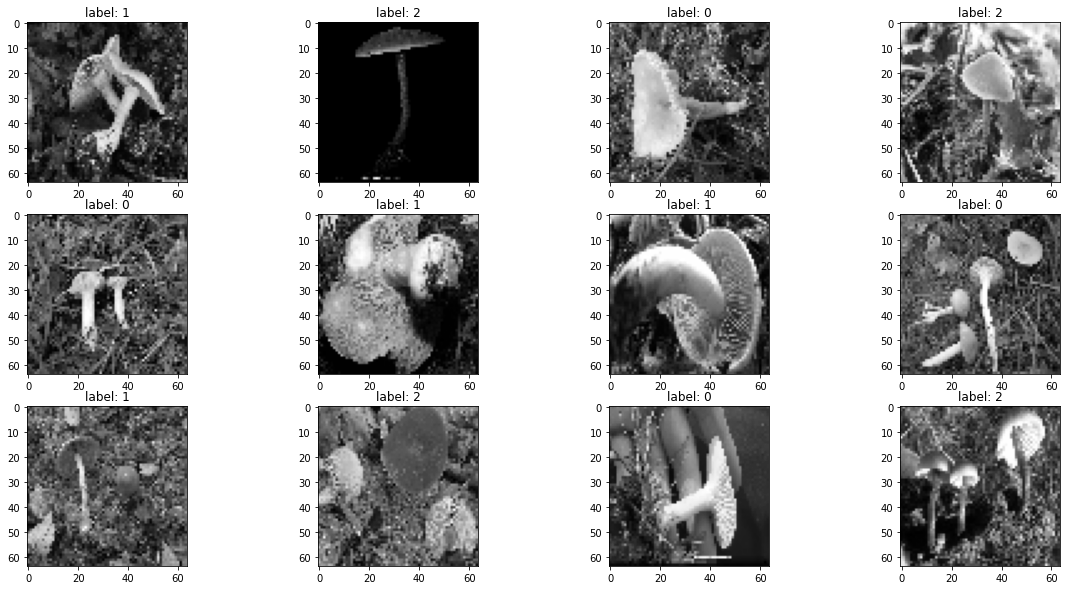

In [15]:

plt.figure(figsize=(20, 10))
for i in range(len(support_imgs)):
    plt.subplot(3, 4, i+1)
    plt.title(f'label: {support_labels[i]}')
    plt.imshow(support_imgs[i, :, :, 0], cmap='gray')
plt.show()


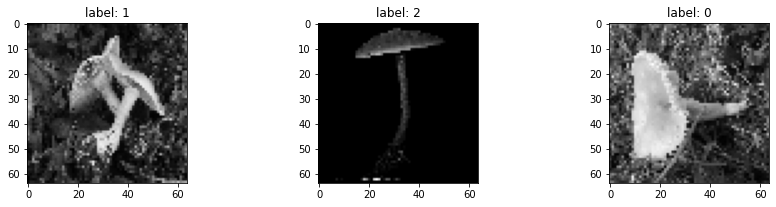

In [16]:

plt.figure(figsize=(20, 10))
for i in range(len(q_imgs)):
    plt.subplot(3, 4, i+1)
    plt.title(f'label: {support_labels[i]}')
    plt.imshow(support_imgs[i, :, :, 0], cmap='gray')
plt.show()


In [17]:

def conv_bn(x):
    x = layers.Conv2D(filters=64, kernel_size=3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D()(x)
    return x


inputs = layers.Input(shape=(64, 64, 1))
x = conv_bn(inputs)
x = conv_bn(x)
x = conv_bn(x)
x = conv_bn(x)
x = layers.Flatten()(x)
outputs = layers.Dense(n_way, activation="softmax")(x)
model = keras.Model(inputs=inputs, outputs=outputs)


inner_optimizer = keras.optimizers.Adam(learning_rate=inner_lr)
outer_optimizer = keras.optimizers.Adam(learning_rate=outer_lr)

model.compile(optimizer=inner_optimizer, 
              loss=keras.losses.sparse_categorical_crossentropy)

In [18]:
def maml(model, batch_data, inner_optimizer, outer_optimizer, inner_step=1, training=True):
    meta_support_image, meta_support_label, meta_query_image, meta_query_label = next(batch_data)
    batch_acc = []
    batch_loss = []

    for support_image, support_label, query_image, query_label in zip(meta_support_image, meta_support_label, meta_query_image, meta_query_label):
        # 保存一開始model weights
        meta_weights = model.get_weights()

        # inner loop training
        for _ in range(inner_step):
            with tf.GradientTape() as tape:
                logits = model(support_image, training=True)
                loss = keras.losses.sparse_categorical_crossentropy(support_label, logits)
                loss = tf.reduce_mean(loss)
            grads = tape.gradient(loss, model.trainable_variables)
            inner_optimizer.apply_gradients(zip(grads, model.trainable_variables))
        
        # outer loop training: 計算query set loss
        with tf.GradientTape() as tape:
            logits = model(query_image, training=True)
            loss = keras.losses.sparse_categorical_crossentropy(query_label, logits)
            loss = tf.reduce_mean(loss)
            acc = (np.argmax(logits, -1) == query_label).astype(np.int32).mean()

            batch_loss.append(loss)
            batch_acc.append(acc)
        # 回復成一開始weights
        model.set_weights(meta_weights)
        
        
        # 在training set中需要更新 meta model
        if training:
            grads = tape.gradient(loss, model.trainable_variables)
            outer_optimizer.apply_gradients(zip(grads, model.trainable_variables))
    return np.array(batch_loss).mean(), np.array(batch_acc).mean()



In [19]:
val_loader.steps

1

In [20]:
val_meta_loss = []
val_meta_acc = []
# Validation
for i in range(val_loader.steps):
    batch_data = val_loader.get_one_batch()
    batch_val_loss, batch_val_acc = maml(model, batch_data, inner_optimizer, outer_optimizer, inner_step=1, training=False)
    val_meta_loss.append(batch_val_loss)
    val_meta_acc.append(batch_val_acc)
print(val_meta_acc,val_meta_loss)

ResourceExhaustedError: OOM when allocating tensor with shape[12,64,64,64] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:FusedBatchNormGradV3]

In [ ]:
batch_data = val_loader.get_one_batch()
 
maml(model, batch_data, inner_optimizer, outer_optimizer, inner_step=1, training=True)

In [ ]:
train_meta_loss = []
train_meta_acc = []
val_meta_loss = []
val_meta_acc = []

for meta_iter in tqdm(range(epochs)):
    # Training
    for i in tqdm(range(train_loader.steps), leave=False):
        batch_data = train_loader.get_one_batch() # batch_sup_img, batch_sup_label, batch_query_img, batch_query_label
        batch_train_loss, batch_train_acc = maml(model, batch_data, inner_optimizer, outer_optimizer, inner_step=1, training=True)
        train_meta_loss.append(batch_train_loss)
        train_meta_acc.append(batch_train_acc)
    # Validation
    for i in range(val_loader.steps):
        batch_data = val_loader.get_one_batch()
        batch_val_loss, batch_val_acc = maml(model, batch_data, inner_optimizer, outer_optimizer, inner_step=6, training=False)
        val_meta_loss.append(batch_val_loss)
        val_meta_acc.append(batch_val_acc)
    print(f'[epoch {meta_iter:05d}]: train_loss: {np.mean(train_meta_loss):.4f} val_loss: {np.mean(val_meta_loss):.4f} train_acc: {np.mean(train_meta_acc):.3f} val_acc: {np.mean(val_meta_acc):.3f}')


In [37]:
conda list cudnn


Note: you may need to restart the kernel to use updated packages.


'conda' is not recognized as an internal or external command,
operable program or batch file.


In [ ]:
# backup model weights
w = model.get_weights()
# read kaggle test1.csv file row by row
for row in "test1.csv":
    # restore model weights at the begining of adaptation
    model.set_weights(w)
    # each row is a task (3 way 1 shot) for adaptation
    # read imgs and label (support_0: class 0, support_1: class 1, support_2: class 2)
    imgs, labels = read_img()

    # update model N times by (imgs, labels)

    # use adapted model to predict img in "filename" column
    y_pred = model.predict(img_filename)
    # get predict class and save to submission file

    